In [27]:
import sys
sys.path.append('../') # path to bemcs
import numpy as np
import matplotlib.pyplot as plt
import bemcs
import bemcs.kernels_stress_displacement as kernels

np.random.seed(43)

# Example 1: Sinusoidal fault

For a sinusoidal fault in an $x,y$ coordinate system, $y = A\sin\left(\frac{2n\pi}{L}\right)$ where $A$ is the amplitude, $n$ is the number of cycles of the sinusoid and $L$ is the fault length in the $x$ dimension.

Forcing slip vector at patch centers to be purely shear


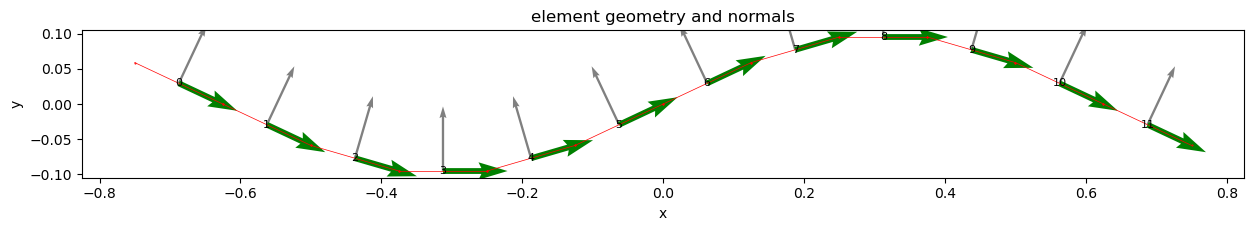

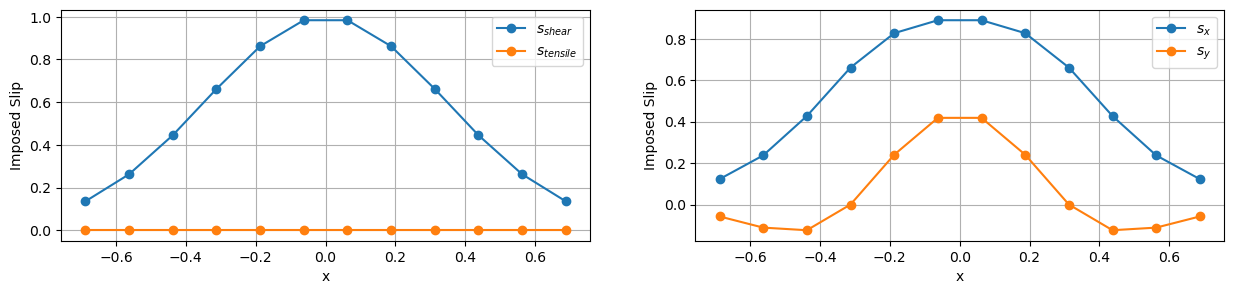

In [32]:
# use a non-uniform mesh
n_elements = 12
L_fault = 1.5 # fault length in x

# specify amplitude and number of wavelengths for sinusoidal fault geometry
y_amplitude,lambda_cycles = 0.1,1.2

# flag for slip to be purely shear
slip_purely_shear = True

# sinusoidal y-positions for fault elements
sorted_xlocs = np.linspace(-L_fault/2 + L_fault/n_elements,L_fault/2-L_fault/n_elements,n_elements-1)

# rough fault
x1 = np.concatenate((np.array([-L_fault/2.]), sorted_xlocs))
x2 = np.concatenate((sorted_xlocs,np.array([L_fault/2.])))
y1 = y_amplitude*np.sin(lambda_cycles*2*np.pi*x1/L_fault)
y2 = y_amplitude*np.sin(lambda_cycles*2*np.pi*x2/L_fault)

elements = []
element = {}
for i in range(n_elements):
    element["x1"] = x1[i]
    element["y1"] = y1[i]
    element["x2"] = x2[i]
    element["y2"] = y2[i]
    elements.append(element.copy())
elements = bemcs.standardize_elements(elements)

# slip imposed at central nodes of each patch (these are in x,y coordinates)
slip_vector_s = np.exp(-(np.linspace(-1,1,n_elements)**2)/2/(0.5**2))
slip_vector_n = np.zeros_like(slip_vector_s)
slip_vector_x = np.zeros_like(slip_vector_s)
slip_vector_y = np.zeros_like(slip_vector_s)

# force slip vector to be purely shear (s_n = 0)
if slip_purely_shear==True:
    slip_vector = np.vstack((slip_vector_s,slip_vector_n)).T
    print("Forcing slip vector at patch centers to be purely shear")
    for i in range(len(elements)):
        slip_vector_x[i],slip_vector_y[i] = slip_vector[i,:]@elements[i]["inverse_rotation_matrix"]
else:
    slip_vector_x = slip_vector_s
    slip_vector_y = slip_vector_n

# plot geometry of mesh
plt.figure(figsize=(15,5))
bemcs.plot_element_geometry(elements)

# plot slip function
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot((x1+x2)/2,slip_vector_s,'o-',label='$s_{shear}$')
plt.plot((x1+x2)/2,slip_vector_n,'o-',label='$s_{tensile}$')
plt.xlabel('x')
plt.ylabel('Imposed Slip')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot((x1+x2)/2,slip_vector_x,'o-',label='$s_x$')
plt.plot((x1+x2)/2,slip_vector_y,'o-',label='$s_y$')
plt.xlabel('x')
plt.ylabel('Imposed Slip')
plt.grid()
plt.legend()
plt.show()